#**Table of Contents**
1. Introduction
2. Methodology
3. Libraries
4. Dataset
5. Base Map
  - 5.1 Load Regions Geometries and Preprocess
  - 5.2 Generate Base Map
6. Dengue Incidences and Dengue Fatality Rates
  - 6.1 Load Dengue Data
  - 6.2 Dengue Incidences Mapping
    - 6.2.1 Preprocess
    - 6.2.2 Total Dengue Incidences by Region Mapping
    - 6.2.3 Yearly Dengue Incidences by Region Mapping
    - 6.2.4 Seasonal Dengue Incidences by Region Mapping
  - 6.3 Dengue Fatality Rates Mapping
    - 6.3.1 Preprocess
    - 6.3.2 Total Dengue Fatality Rates by Region Mapping
    - 6.3.3 Yearly Dengue Fatality Rates by Region Mapping
7. Autocorrelation of Dengue Incidences and Dengue Fatality Rates
  - 7.1 Dengue Incidences Moran's I and Moran's Plot
  - 7.2 Dengue Fatality Rates Moran's I and Moran's Plot
8. Healthcare Facilites
  - 8.1 Load Healthcare Facilities Data
  - 8.2 Preprocess Data
  - 8.3 Healthcare Facilities Mapping
  - 8.4 Join Healthcare Facilities by Region
  - 8.5 Healthcare Facilities by Region Mapping
9. Correlation of Healthcare Facilities with Dengue Fatality Rates
  - 9.1 Correlation Score and Scatter Plot
  - 9.2 Clustering Map for Healthcare Facilities and Dengue Fatality Rates using Local Moran
10. Low Survival Rate Regions with Low Access to Healthcare


#**1. Introduction**

As Philippines is a tropical country and climate is favorable for breeding of Aedes mosquitoes, dengue outbreaks occurs frequently and damage from the outbreak may vary between regions. We might want to identify regions with poor survival rate and might want to increase region's survival rate for dengue outbreak.

#**2. Methodology**


In this notebook, we will be taking a look at the Spatial Autocorrelation of the recent dengue cases from the Philippines (2016-2020) and on a regional basis. We will explore what regions tends to cluster with dengue incidence and dengue fatalities, are there any clustering observe during those times. Do we expect dengue incidences to cluster more than dengue fatalities or vise versa. We'll also observe these phenomenon on monthly and yearly basis see if there's significant clustering. And lastly, we'll be taking a look at the distribution of healthcare facilities nationwide and its correlation to the dengue fatalities. Can we really observe clustering of dengue fatalities inversely proportional with the clustering of healthcare facilities, and if so, what are the regions needed additional access to healthcare facilities to atleast minimize dengue fatalities?

**Approach**:
 - Map dengue data with the use of "Natural Breaks" on yearly and monthly manner and "Quantiles" for generality of such case
 - Bin dengue cases to the nearest hundreds for mapping
 - Normalize dengue casualties per 100 cases showing dengue fatality rates for mapping and autocorrelation
 - Autocorrelation of dengue cases and dengue fatality rates using Global Moran
 - Correlation of dengue fatality rates to the distribution of healthcare facilities nationwide using Pearson
 - Compare clustering of dengue fatalities along the clustering of health facilities using Moran Local

# **3. Libraries**


In [ ]:
# Install through the given requirements text file
!pip install -r 'requirements.txt'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.4/132.4 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 55.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.8/331.8 kB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.4/215.4 kB 27.1 MB/s eta 0:00:00


In [ ]:
# Import tools and library
import pandas as pd
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.express as px
from datetime import datetime
import mapclassify
import numpy as np
import libpysal
from esda import Moran, Moran_Local
from splot.esda import moran_scatterplot, lisa_cluster
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.patches as mpatches

# **4. Dataset**

Access of files used in this notebook can be found [here](https://drive.google.com/drive/folders/1ENYyiBuLLif6Hunhv-s0THBw677qf8HI?usp=sharing) and original dataset can be found within the following:
- [Philippines GeoJSON Polygon Dataset](https://github.com/faeldon/philippines-json-maps/tree/master/2023/geojson)
- [Philippines Dengeue Cases 2016-2020 Dataset](https://www.kaggle.com/datasets/vincentgupo/dengue-cases-in-the-philippines)
- [Philippines Healthcare Facilities Dataset](https://data.humdata.org/dataset/philippines-healthsites)



# **5. Basemap**


### Load Regions Geometries and Preprocess


In [ ]:
# Prepare variables in order to fully load the basemap properly
file_names = ['reg1', 'reg2', 'reg3', 'reg4a',
              'reg4b', 'reg5', 'reg6', 'reg7',
              'reg8', 'reg9', 'reg10', 'reg11',
              'reg12', 'reg13', 'ncr', 'car', 'barmm']
region_name = ['Region I', 'Region II', 'Region III', 'Region IV-A',
               'Region IV-B', 'Region V', 'Region VI', 'Region VII',
               'Region VIII', 'Region IX', 'Region X', 'Region XI',
               'Region XII', 'Region XIII', 'NCR', 'CAR', 'BARMM']
regional_geojsons = pd.DataFrame()

# Loop to load all regional geojson file
for i in range(len(file_names)):
  loaded_df = gpd.read_file(file_names[i]+'.geojson')
  loaded_df['region'] = region_name[i]
  regional_geojsons = pd.concat([regional_geojsons, loaded_df], ignore_index=True)


# Reproject geometries to a new CRS (EPSG:3857)
regional_geojsons = regional_geojsons.to_crs(epsg=3857)
regional_geojsons.head(15)


adm1_psgc  adm2_psgc        adm2_en geo_level  len_crs     area_crs  \
0   100000000  102800000   Ilocos Norte      Prov   309785   3276945154   
1   100000000  102900000     Ilocos Sur      Prov   452374   2467458323   
2   100000000  103300000       La Union      Prov   262415   1414080983   
3   100000000  105500000     Pangasinan      Prov   789136   5161200257   
4   200000000  200900000        Batanes      Prov   230060    201280837   
5   200000000  201500000        Cagayan      Prov  1135169   8794377504   
6   200000000  203100000        Isabela      Prov   606202  10489909469   
7   200000000  205000000  Nueva Vizcaya      Prov   403864   4126548282   
8   200000000  205700000        Quirino      Prov   323147   2767354533   
9   300000000  300800000         Bataan      Prov   290679   1246275464   
10  300000000  301400000        Bulacan      Prov   357485   2710754756   
11  300000000  304900000    Nueva Ecija      Prov   417819   5506443156   
12  300000000  305400000       Pampanga      Prov   291563   2115903632   
13  300000000  306900000         Tarlac      Prov   275154   2974676788   
14  300000000  307100000       Zambales      Prov   582660   3733936862   

    len_km  area_km2                                           geometry  \
0      309      3276  POLYGON ((13421993.865 2012519.251, 13422231.6...   
1      452      2467  MULTIPOLYGON (((13421993.865 2012519.251, 1341...   
2      262      1414  POLYGON ((13421241.630 1882417.525, 13421009.7...   
3      789      5161  MULTIPOLYGON (((13349742.255 1855717.878, 1334...   
4      230       201  MULTIPOLYGON (((13575282.605 2404161.809, 1357...   
5     1135      8794  MULTIPOLYGON (((13576483.627 2211039.825, 1357...   
6      606     10489  MULTIPOLYGON (((13600232.687 1988976.740, 1359...   
7      403      4126  POLYGON ((13519279.382 1878296.698, 13517792.4...   
8      323      2767  POLYGON ((13587524.375 1863773.383, 13582951.9...   
9      290      1246  POLYGON ((13420039.347 1668549.346, 13419513.4...   
10     357      2710  POLYGON ((13504407.059 1712118.335, 13503316.7...   
11     417      5506  POLYGON ((13501358.113 1776300.432, 13500865.5...   
12     291      2115  POLYGON ((13440070.885 1721162.488, 13439651.2...   
13     275      2974  POLYGON ((13426807.469 1783373.539, 13426475.1...   
14     582      3733  MULTIPOLYGON (((13386486.784 1760500.297, 1338...   

        region  
0     Region I  
1     Region I  
2     Region I  
3     Region I  
4    Region II  
5    Region II  
6    Region II  
7    Region II  
8    Region II  
9   Region III  
10  Region III  
11  Region III  
12  Region III  
13  Region III  
14  Region III

### Generate Base Map

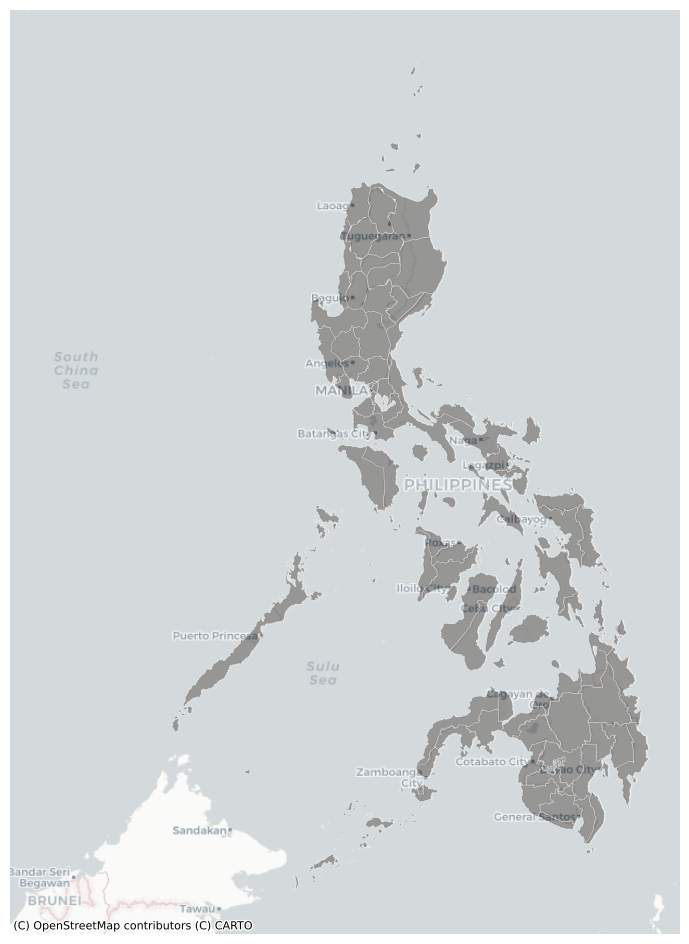

In [ ]:
# Plot the base map
fig, ax = plt.subplots(figsize=(12,12))

regional_geojsons.plot(ax=ax,
         color='black',
         edgecolor='white',
         lw=0.5,
         alpha=0.4)

ax.axis('off')
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

> *Next Step*
- Since base map of Philippines is now generated, we will look at the dengue incidences mapped onto regions as well as for dengue fatalities and see if there are observable spatial patterns.

# **6. Dengue Incidences and Dengue Fatality Rates**

We will preprocess dengue data as such and chose to utilize 2 map classifiers:


> **Preprocessing:**
- **Bin** with the nearest hundreds on dengue incidences is used to remove noise on mapping the data accross regions
- **Normalize** dengue deaths per 100 dengue cases is used to highlight damage across regions

> **Mapping Classifier:**
- **Jenks (Natural Breaks)** is used to highlight natural patterns such as clusters can be affected due to environmental and socioeconomic factors.
- **Quantiles** is used to easily comparison of data (incidences and fatality rates) between regions as the approach ensures each class to have same number of data points.



### 6.1 Load Dengue Data

In [ ]:
# Load dengue data
dengue_ph = pd.read_csv('ph_dengue_cases_2016-2020.csv')
dengue_ph

Month  Year    Region  Dengue_Cases  Dengue_Deaths
0       January  2016  Region I           705              1
1      February  2016  Region I           374              0
2         March  2016  Region I           276              0
3         April  2016  Region I           240              2
4           May  2016  Region I           243              1
...         ...   ...       ...           ...            ...
1015     August  2020     BARMM            91              0
1016  September  2020     BARMM            16              8
1017    October  2020     BARMM            13              9
1018   November  2020     BARMM            15              1
1019   December  2020     BARMM            23              0

[1020 rows x 5 columns]

### 6.2 Dengue Incidences Mapping

6.2.1 Preprocess

In [ ]:
# Total Dengue Incidences by Region Preprocess

# Aggregate total dengue incidences per region
dengue_ph_regional = dengue_ph.groupby(['Region'])['Dengue_Cases'].sum().reset_index()

# Bin dengue incidences to nearest hundreds
dengue_ph_regional['Dengue_Cases_Bin'] = np.ceil(dengue_ph_regional['Dengue_Cases'] / 100) * 100

# Merge data with the basemap
dengue_ph_regional.rename(columns={'Region':'region'}, inplace=True)
dengue_ph_regional = regional_geojsons.merge(dengue_ph_regional, on="region")



# Yearly Dengue by Region Incidences Preprocess

# Aggregate yearly total dengue incidences per region
dengue_ph_agg = dengue_ph.groupby(['Region', 'Year'])['Dengue_Cases'].sum().reset_index()

# Bin dengue incidences to nearest hundreds
dengue_ph_agg['Dengue_Cases_Bin'] = np.ceil(dengue_ph_agg['Dengue_Cases'] / 100) * 100

# Merge data with the basemap
dengue_ph_agg.rename(columns={'Region':'region'}, inplace=True)
dengue_regional_cases = regional_geojsons.merge(dengue_ph_agg, on="region")

# Get unique years
years = dengue_regional_cases['Year'].unique()



# Seasonal Dengue Incidences by Region Preprocess

# Aggregate monthly total dengue incidences per region
dengue_ph_agg_mnt = dengue_ph.groupby(['Region', 'Month'])['Dengue_Cases'].sum().reset_index()

# Bin dengue incidences to nearest hundreds
dengue_ph_agg_mnt['Dengue_Cases_Bin'] = np.ceil(dengue_ph_agg_mnt['Dengue_Cases'] / 100) * 100

# Merge data with the basemap
dengue_ph_agg_mnt.rename(columns={'Region':'region'}, inplace=True)

# Get unique months and in sorted way
months = dengue_ph_agg_mnt['Month'].unique()
months =  sorted(months, key=lambda month: datetime.strptime(month, "%B").month)

6.2.2 Total Dengue Incidences by Region Mapping

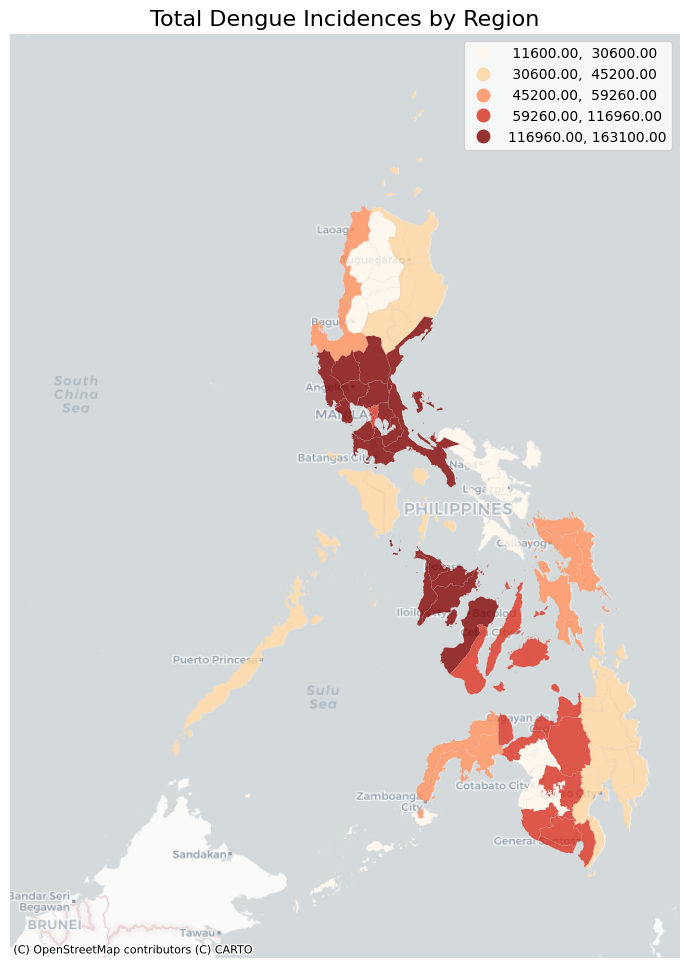

In [ ]:
# Map Total Dengue Incidences by Region
fig, ax = plt.subplots(figsize=(12,12))
dengue_ph_regional.plot(ax=ax,
          column='Dengue_Cases_Bin',
          legend=True,
          edgecolor='lightgrey',
          lw=0.1,
          alpha=0.8,
          cmap='OrRd',
          scheme='quantiles')
ax.axis('off')
ax.set_title('Total Dengue Incidences by Region', fontsize=16)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

> *Insights*
-  Dengue incidences may seem to be spatially dispered across regions

6.2.3 Yearly Dengue Incidences by Region Mapping

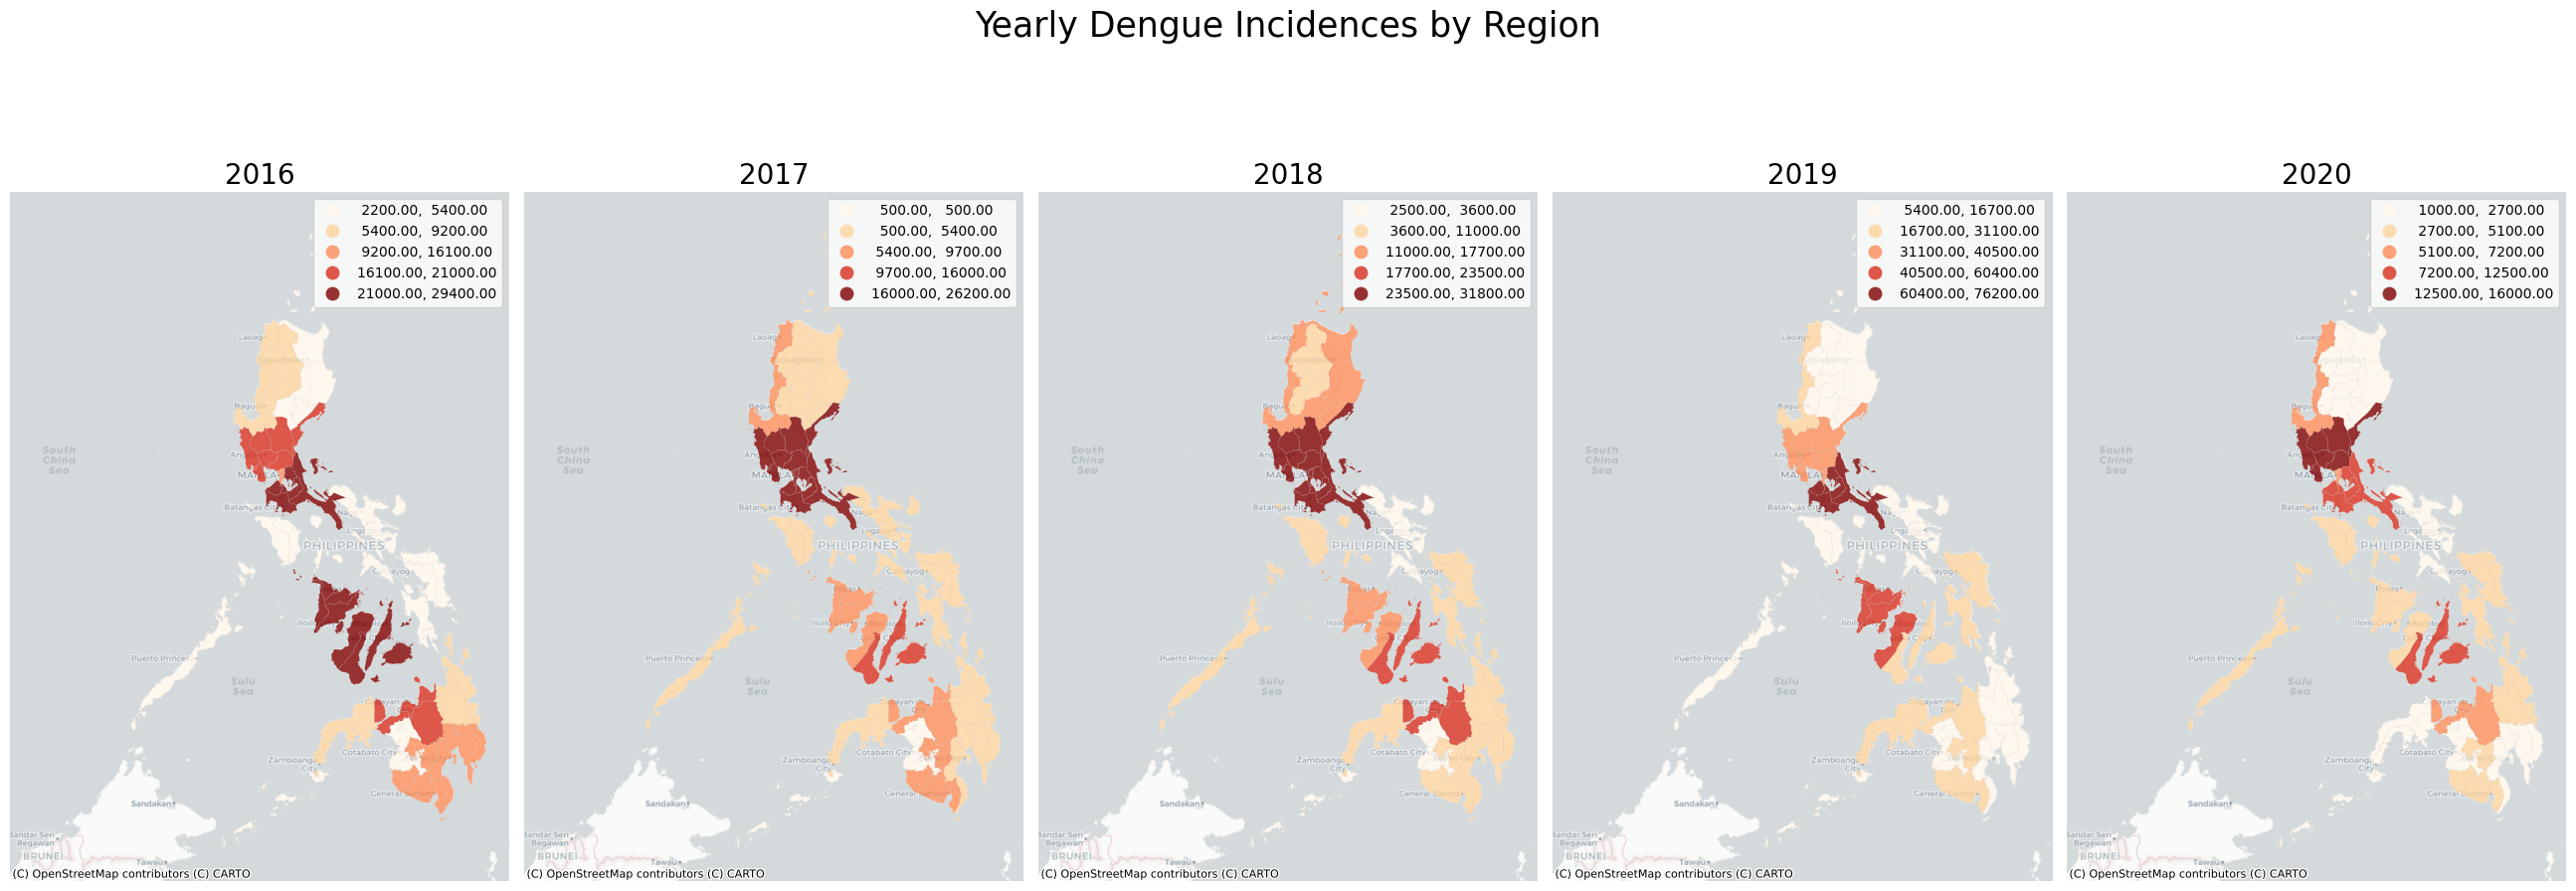

In [ ]:
# Map Yearly Regional Dengue Incidences
fig, axes = plt.subplots(1,5, figsize=(26,10))
fig.suptitle('Yearly Dengue Incidences by Region', fontsize=25)

# Loop through years to display subset of data in subplots in defined dimension
for i in range(len(years)):
  dengue_regional_cases_yr = dengue_regional_cases[dengue_regional_cases['Year'] == years[i]]
  dengue_regional_cases_yr.plot(ax=axes[i],
          column='Dengue_Cases_Bin',
          legend=True,
          alpha=0.8,
          edgecolor='lightgrey',
          lw=0.1,
          cmap='OrRd',
          scheme='natural_breaks')
  axes[i].axis('off')
  axes[i].set_title(str(years[i]), fontsize=20)
  ctx.add_basemap(axes[i], source=ctx.providers.CartoDB.Positron)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

> *Insights*
- We tend to observe some spatial patterns as some regions that has severe dengue incidences almost yearly on Central Luzon, Western Visayas and Central Mindanao

6.2.4 Seasonal Dengue Incidences by Region Mapping

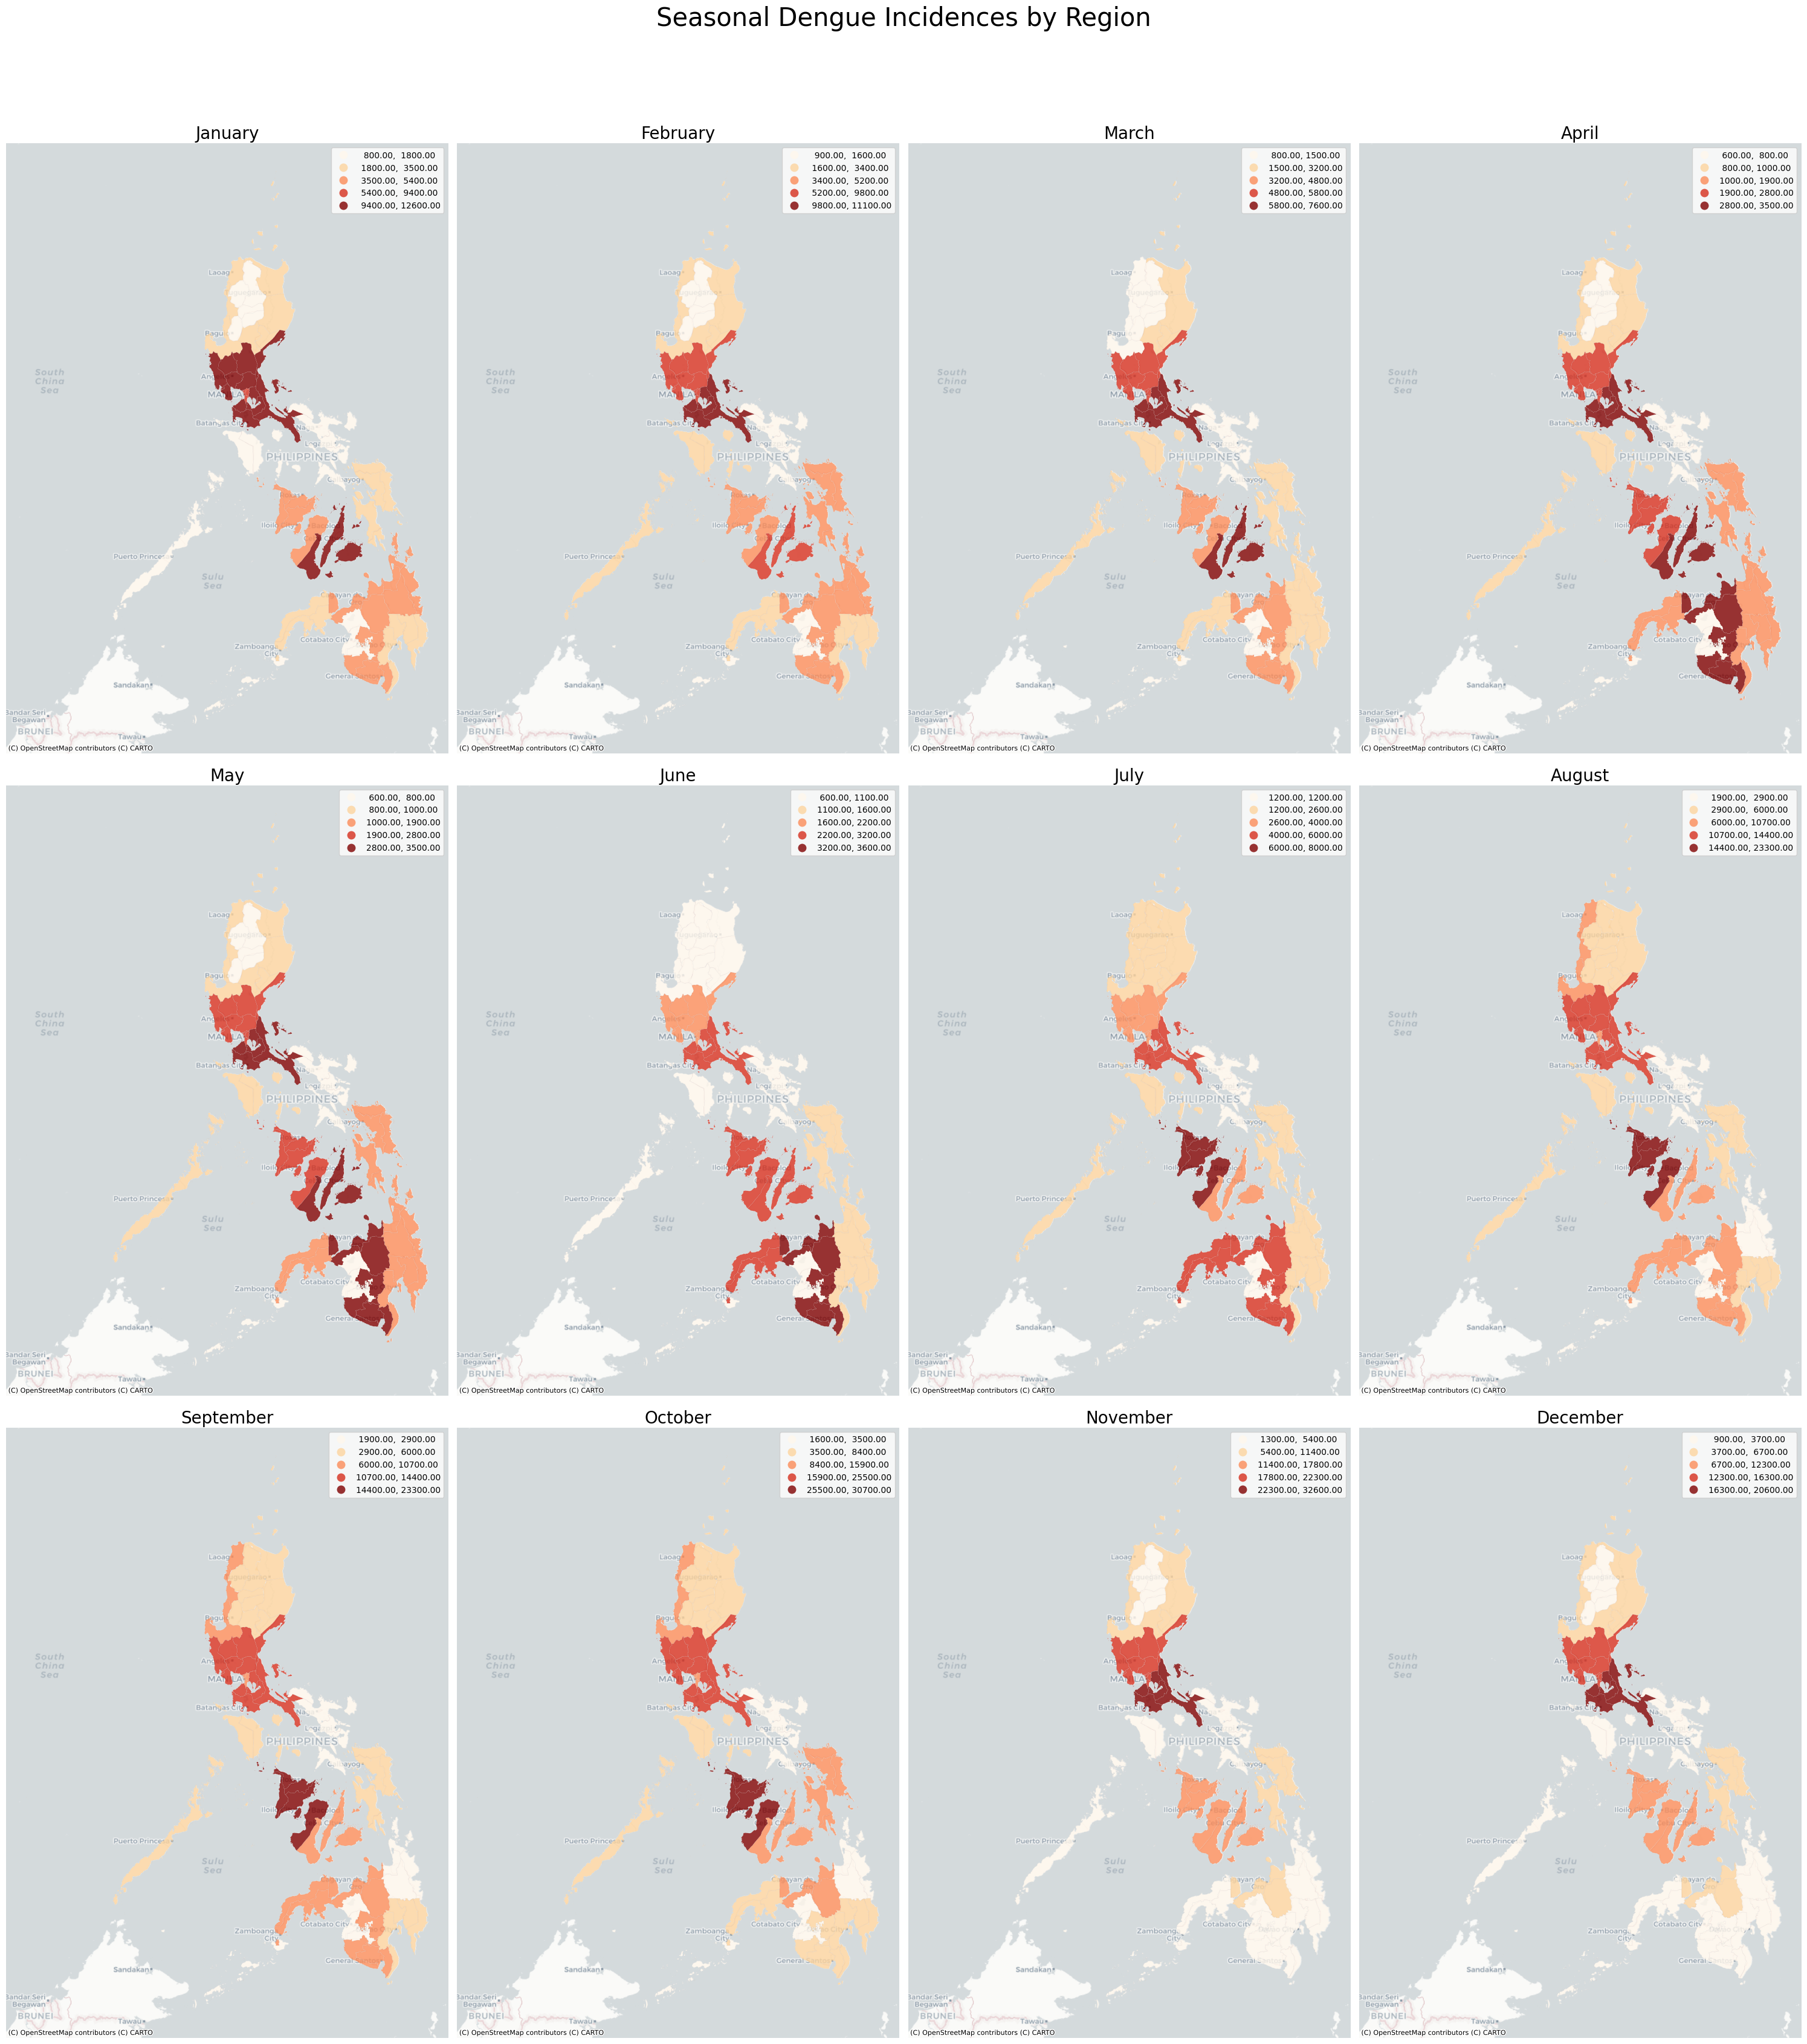

In [ ]:
# Map Seasonal Dengue Incidences by Region
fig, axes = plt.subplots(3, 4, figsize=(30,35))
fig.suptitle('Seasonal Dengue Incidences by Region', fontsize=30)

# Loop through monthsto display subset of data in subplots in defined dimension
for i in range(3):
  for j in range(4):
    dengue_regional_cases_on_months = dengue_ph_agg_mnt[dengue_ph_agg_mnt['Month'] == months[3* i + j]]
    dengue_regional_cases_on_months = regional_geojsons.merge(dengue_regional_cases_on_months, on="region")
    dengue_regional_cases_on_months.plot(ax=axes[i][j],
            column='Dengue_Cases_Bin',
            legend=True,
            alpha=0.8,
            edgecolor='lightgrey',
            lw=0.1,
            cmap='OrRd',
            scheme='natural_breaks')
    axes[i][j].axis('off')
    axes[i][j].set_title(str(months[4 * i + j]), fontsize=20)
    ctx.add_basemap(axes[i][j], source=ctx.providers.CartoDB.Positron)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

> *Insights*
- We tend to see dispersion of dengue incidence from months of January to October and during peaks months (April and May) we then observe so much dispersion accross regions but then we only able to see it cluster significantly around November and December on Central Luzon, Middle and South Part of Visayas and small part of Northern Mindanao

### 6.3 Dengue Fatality Rates Mapping


6.3.1 Preprocess

In [ ]:
# Total Dengue Fatality Rates by Region Preprocess

# Aggregate yearly dengue cases and dengue fatalities per region
dengue_ph_cases_agg = dengue_ph.groupby(['Region'])['Dengue_Cases'].sum().reset_index()
dengue_ph_deaths_agg = dengue_ph.groupby(['Region'])['Dengue_Deaths'].sum().reset_index()

# Merge dengue cases and dengue fatalities on regional basis
dengue_ph_tot = dengue_ph_cases_agg.merge(dengue_ph_deaths_agg, on="Region", how="inner")

# Normalize dengue fatalities data
dengue_ph_tot['Dengue_Deaths_Per_100_Cases'] = dengue_ph_tot['Dengue_Deaths']/dengue_ph_tot['Dengue_Cases']*100

# Merge data with the base map
dengue_ph_tot.rename(columns={'Region':'region'}, inplace=True)
dengue_regional_deaths_total = regional_geojsons.merge(dengue_ph_tot, on="region")


# Yearly Dengue Fatality Rates by Region Preprocess

# Aggregate yearly dengue cases and dengue fatalities per region
dengue_ph_cases = dengue_ph.groupby(['Region', 'Year'])['Dengue_Cases'].sum().reset_index()
dengue_ph_deaths = dengue_ph.groupby(['Region', 'Year'])['Dengue_Deaths'].sum().reset_index()

# Merge dengue cases and dengue fatalities on regional basis and year basis
dengue_ph_fin = dengue_ph_cases.merge(dengue_ph_deaths, on=["Region", "Year"], how="inner")

# Normalize dengue fatalities data
dengue_ph_fin['Dengue_Deaths_Per_100_Cases'] = dengue_ph_fin['Dengue_Deaths']/dengue_ph_fin['Dengue_Cases']*100

# Merge data with the base map
dengue_ph_fin.rename(columns={'Region':'region'}, inplace=True)
dengue_regional_deaths_ann = regional_geojsons.merge(dengue_ph_fin, on="region")

# Get unique years
years = dengue_regional_deaths_ann['Year'].unique()


6.3.2 Total Dengue Fatality Rates by Region Mapping

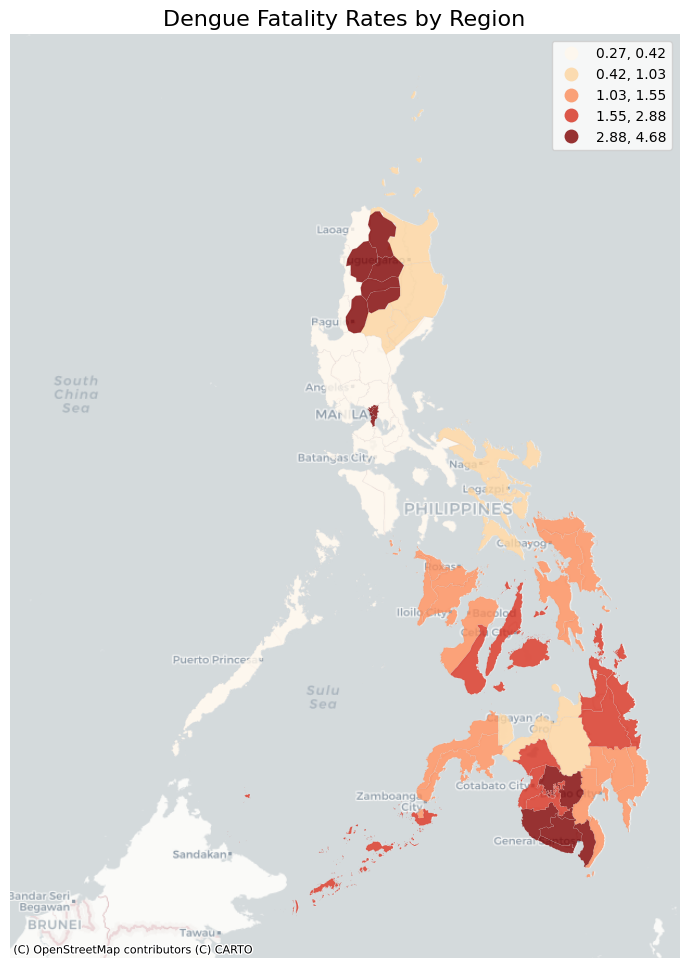

In [ ]:
# Map Total Dengue Fatality Rates by Region
fig, ax = plt.subplots(figsize=(12,12))
dengue_regional_deaths_total.plot(ax=ax,
          column='Dengue_Deaths_Per_100_Cases',
          legend=True,
          alpha=0.8,
          edgecolor='lightgrey',
          lw=0.1,
          cmap='OrRd',
          scheme='quantiles')
ax.axis('off')
ax.set_title('Dengue Fatality Rates by Region', fontsize=16)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

> *Insights*
- Visible but little significant clustering of dengue fatalities observed at the regions of the Pihlippines

6.3.2 Yearly Dengue Fatality Rates by Region Mapping

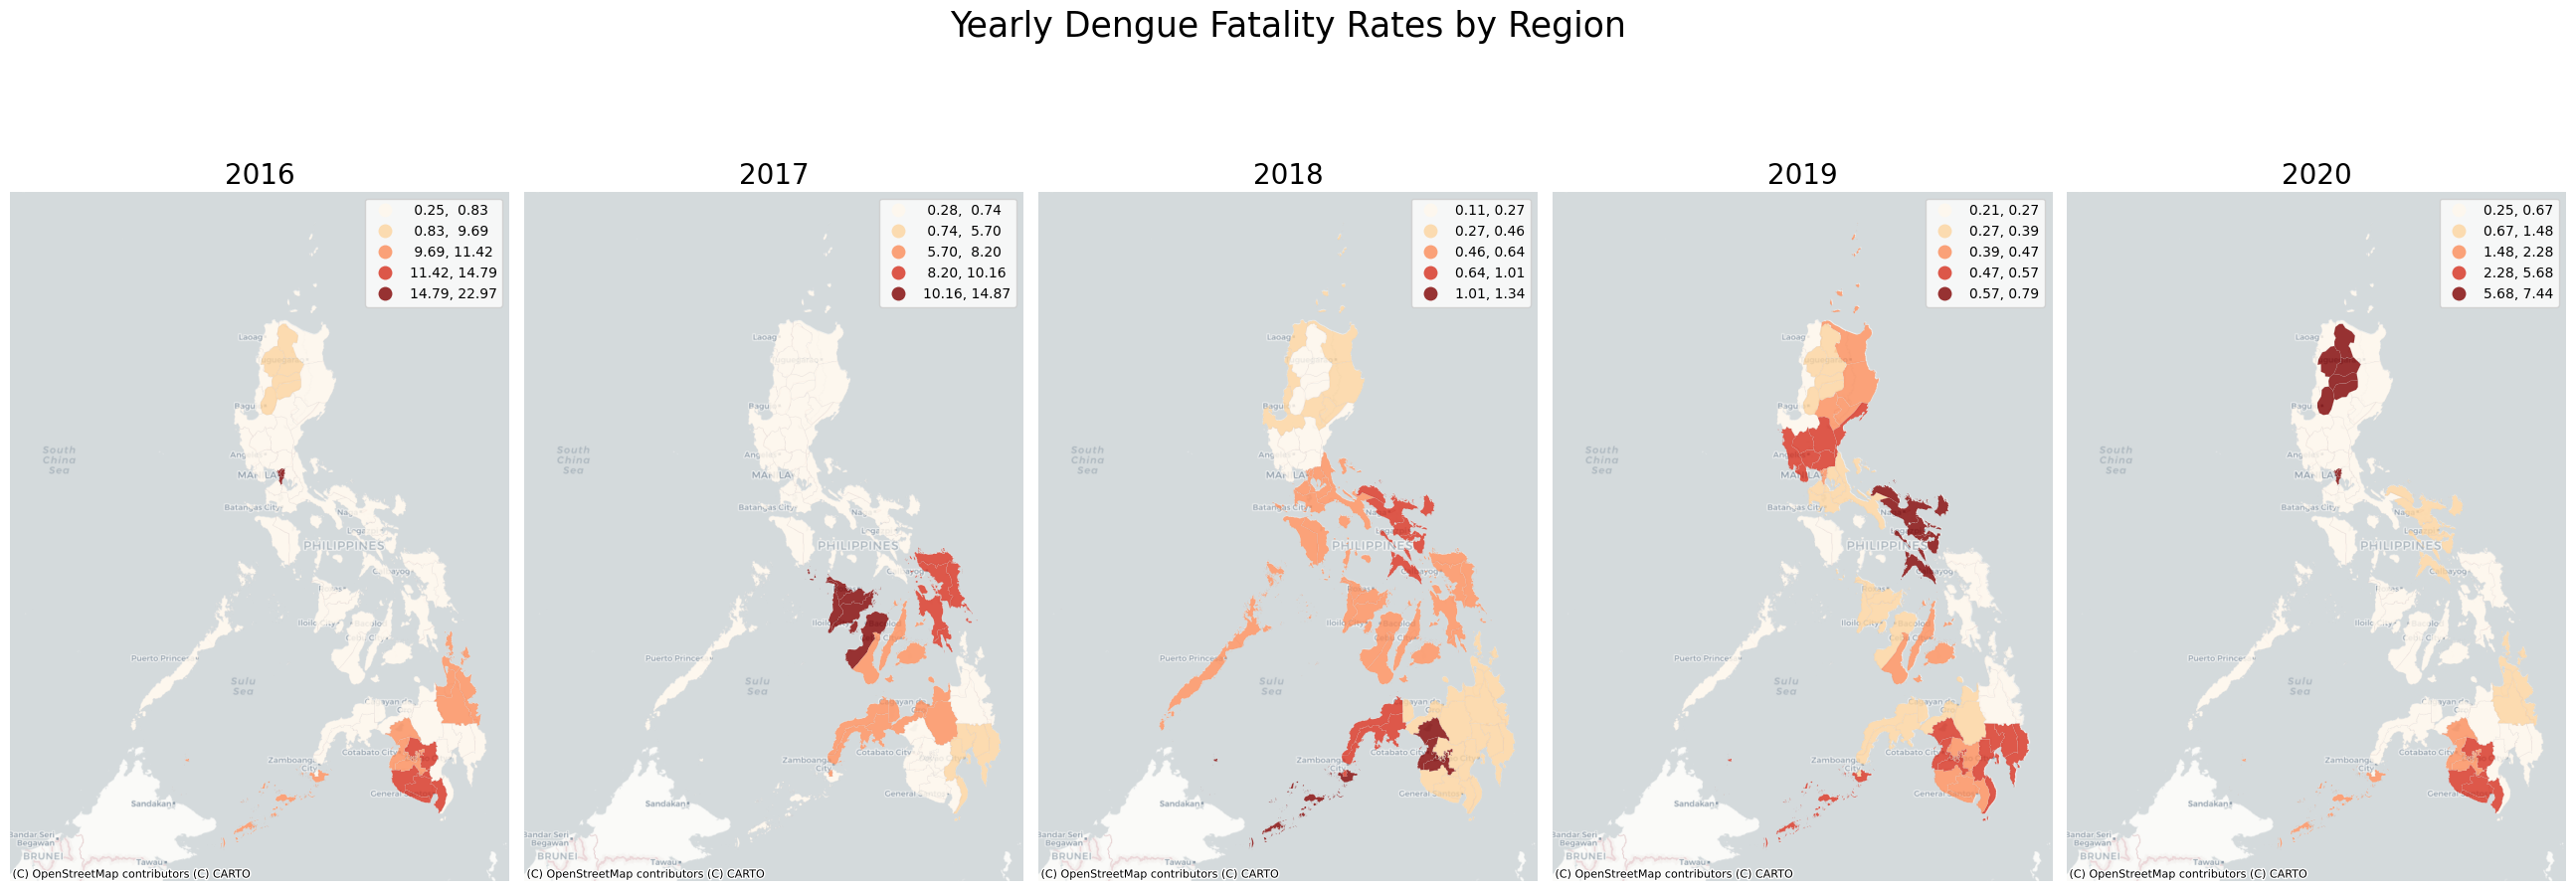

In [ ]:
# Map Yearly Dengue Fatality Rates by Region Mapping
fig, axes = plt.subplots(1,5, figsize=(26,10))
fig.suptitle('Yearly Dengue Fatality Rates by Region', fontsize=25)

# Loop through years to display subset of data in subplots in defined dimension
for i in range(len(years)):
  dengue_regional_deaths_yr = dengue_regional_deaths_ann[dengue_regional_deaths_ann['Year'] == years[i]]
  dengue_regional_deaths_yr.plot(ax=axes[i],
        column='Dengue_Deaths_Per_100_Cases',
        legend=True,
        alpha=0.8,
        edgecolor='lightgrey',
        lw=0.1,
        cmap='OrRd',
        scheme='natural_breaks')
  axes[i].axis('off')
  axes[i].set_title(str(years[i]), fontsize=20)
  ctx.add_basemap(axes[i], source=ctx.providers.CartoDB.Positron)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

> *Insights*
- There is some clustering between years especially if looking at Northern Luzon and some part of Mindanao, supporting the evidence of spatial pattern when it comes to dengue fatalities

> *Next Step*
- Looking from the mappings, we do observe quite an evidence of spatial clustering on dengue incidences and dengue fatalities. With that, we'll see how much of spatial correlations there is in dengue incidences and dengue fatalities with Global Moran for Autocorrelation.

# **7. Autocorrelation of Dengue Incidence and Dengue Fatalities**

Spatial weights are constructs used to define spatial relationships between observations. There are different method to get spatial weights but since Philippines used to exists with multiple islands, we will use DistantBand approach allowing a distance threshold of 500 km between neighbors, meaning if an island is isolated, within the distance threshold, can still be considered neighbors for Spatial Autocorrelation.

Spatial autocorellation refer to the correlation of variable with itself through space, which means value of the variable at one location highly depends on neigboring locations. We will be presenting Moran's I (generally the slope of Moran's plot regression line) to quantify the degree of spatial autocorrelation from single summary statistics ranging from -1 to +1.


- **Positive** spatial autocorrelation: high values are close to high values, and/or low values are close to low values
- **Negative** spatial autocorrelation (less common): similar values are far from each other; high values are next to low values, low values are next to high values



*   Score closer to 1 means similar values were strongly clustered together
*   Score of exact 0 indicates no spatial correclation and data were dispered randomly in space
*   Score closer to -1 means dissimilar values were strongly clustered together



Moran's plot (Moran's scatterplot) plots standardized values of a variable against the spatial lag of those values. Spatial lags refers to the likelihood of a given variable or value at a given location, be influened by the value of its corresponding neighbors.

Assessing Moran's plot:
* **Quadrant I (High-High)** indicates regions with high values surrounded with neighbors of high values, therefore suggesting positive autocorrelation
* **Quadrant II (Low-High)** indicates regions with low values surrounded with neighbors of high values
* **Quadrant III (Low-Low)** indicates regions with low values surrounded with neighbors of low values, therefore suggesting positive autocorrelation
* **Quadrant IV (High-Low)** indicates regions with high values surrounded with neighbors of low values

### 7.1 Dengue Incidence Moran's I and Moran's Plot

In [ ]:
# Calculate spatial weights on dengue incidences
w_cases = libpysal.weights.DistanceBand.from_dataframe(dengue_ph_regional, threshold=500000, binary=True)
w_cases.transform = 'r'

# Get autocorrelate score for dengue incidences
moran_cases = Moran(dengue_ph_regional['Dengue_Cases'], w_cases)
moran_cases.I

0.0431042564236556



> *Discussion:*
- With the value of Moran's I at 0.04, indicates that the dengue incidences presents weak spatial correlation between regions.



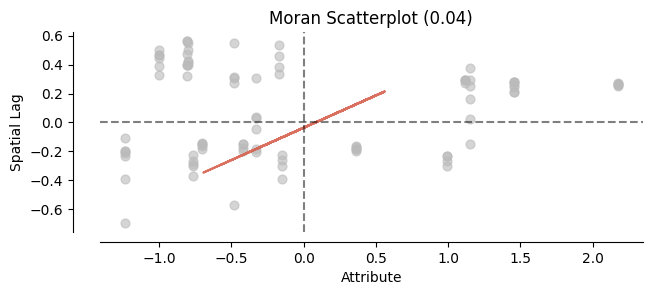

In [ ]:
# Plot moran's scatterplot on dengue incidences
fig, ax = moran_scatterplot(moran_cases, aspect_equal=True)
plt.show()

> *Discussion:*
- Moran's regression line lies on positive quadrants for correlation, the **Quadrant I (High-High)** and **Quadrant III (Low-Low)**, as we do observe significant clustering there, but it's hard to reject we do see a lot of spatial lag from outlier quadrant, the **Quadrant II (Low-High)** leading to a low but still positive score of spatial autocorrelation for dengue incidences


### 7.2 Dengue Fatality Rates Moran's I and Moran's Plot

In [ ]:
# Calculate spatial weights on dengue fatalities
w_deaths = libpysal.weights.DistanceBand.from_dataframe(dengue_regional_deaths_total, threshold=500000, binary=True)
w_deaths.transform = 'r'

# Get autocorrelate score for dengue fatalities
moran_deaths = Moran(dengue_regional_deaths_total['Dengue_Deaths_Per_100_Cases'], w_deaths)
moran_deaths.I

0.09802369378337004

> *Discussion:*
- With the value of Moran's I at 0.09, indicates a greater spatial correlation of dengue fatalites than with the dengue incidences observed regionally



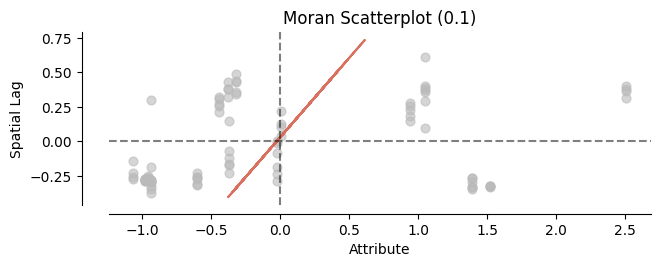

In [ ]:
# Plot moran's scatterplot on dengue fatalities
fig, ax = moran_scatterplot(moran_deaths, aspect_equal=True)
plt.show()

> *Discussion:*
- From here we do observe significant clustering from the **Quadrant I (High-High)** and **Quadrant III (Low-Low)** giving dengue fatalities better autocorrelation score

> *Next Step*
- With dengue fatalities tend to cluster at some areas than dengue cases, there can be several factors to look through but we will take a look at the correlation of healthcare facilities access regionally along with the dengue fatalities.






# **8. Healthcare Facilities**


### 8.1 Load Healthcare Facilities Data



In [ ]:
# Load health sites data
healthsites = pd.read_csv('philippines-healthsites.csv')
healthsites.head()

X          Y      osm_id osm_type  completeness   amenity  \
0  121.064071  14.548507  1585275393     node        15.625  pharmacy   
1         NaN        NaN   399861854      way        18.750    clinic   
2  121.045246  14.675708  1588109986     node        15.625   doctors   
3  121.482202  14.363777  1588281949     node        12.500   doctors   
4         NaN        NaN   400096439      way        15.625  pharmacy   

  healthcare                                        name operator source  ...  \
0   pharmacy                                         TGP      NaN    NaN  ...   
1        NaN                     Saint Odile Surgicenter      NaN    NaN  ...   
2     doctor  Tandang Sora Medical Dental Ob-gyne Clinic      NaN    NaN  ...   
3     doctor                               Garcia Clinic      NaN    NaN  ...   
4        NaN                           Mercury Drugstore      NaN    NaN  ...   

  is_in_health_zone  url addr_housenumber                        addr_street  \
0               NaN  NaN              NaN                                NaN   
1               NaN  NaN              NaN        Marcelo H. del Pilar Avenue   
2               NaN  NaN              NaN                Tandang Sora Avenue   
3               NaN  NaN              NaN                                NaN   
4               NaN  NaN              NaN  National Highway, Bag-ong Lungsod   

   addr_postcode    addr_city  changeset_id  changeset_version  \
0            NaN          NaN    63294186.0                3.0   
1           4001     Alaminos    79182227.0                2.0   
2            NaN          NaN   108444960.0                3.0   
3            NaN          NaN    71595894.0                3.0   
4            NaN  Tandag City   137966717.0                3.0   

      changeset_timestamp                              uuid  
0  2018/10/08 03:04:40+00  1ad6d07310a74921884a95d129fcf778  
1  2020/01/04 07:36:51+00  53593f46144944c4910d1cba319d82a7  
2  2021/07/22 18:19:03+00  61db641d01ba430087813384cd41c3cb  
3  2019/06/25 11:20:43+00  7803d151b19c4615bcab3c5fff189321  
4  2023/06/30 16:54:11+00  155b713014494cc0bbfb7581ae58562f  

[5 rows x 35 columns]

### 8.2 Preprocess Data

In [ ]:
# Drop X and Y if NaN as we are plotting the points from lat and lon
healthsites.dropna(subset=['X', 'Y'], inplace=True)

# Filter to include only 2016 to 2022
start_year = 2016
end_year = 2020
healthsites['changeset_timestamp'] = pd.to_datetime(healthsites['changeset_timestamp'])
healthsites['established_year'] =  healthsites['changeset_timestamp'].dt.year
healthsites = healthsites[(healthsites['established_year'] >= start_year) & (healthsites['established_year'] <= end_year)]

# Convertion to GeoDataFrame
healthsites_geo = gpd.GeoDataFrame(healthsites,
                                   crs='EPSG:4326',
                                   geometry=gpd.points_from_xy(healthsites.X, healthsites.Y))

# Reproject geometries to a new CRS (EPSG:3857)
healthsites_geo = healthsites_geo.to_crs(epsg=3857)

### 8.3 Healthcare Facilities Mapping

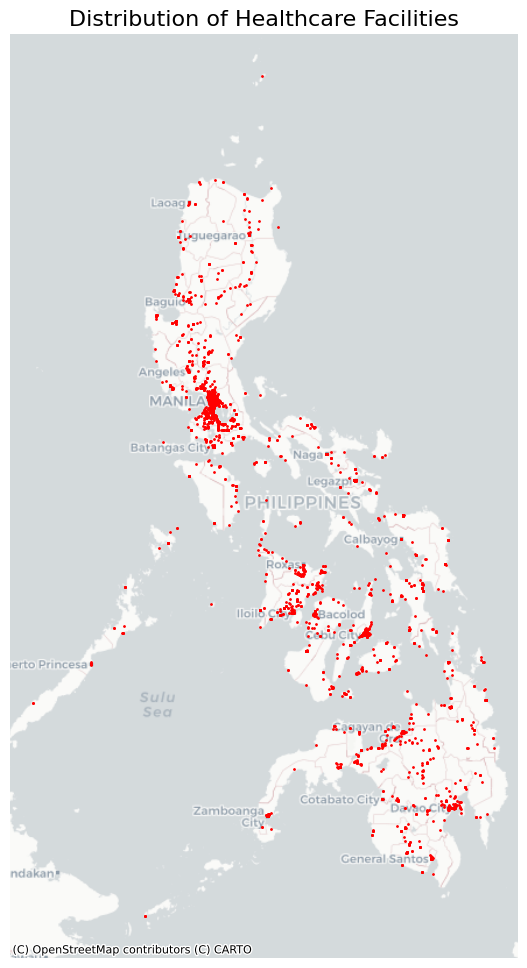

In [ ]:
# Plot Healthcare Facilities Distribution
fig,ax = plt.subplots(figsize=(12,12))

healthsites_geo.plot(ax=ax,
             color='red',
             markersize=1)

ax.axis('off')
ax.set_title('Distribution of Healthcare Facilities', fontsize=16)
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)


### 8.4 Join Healthcare Facilities by Region

In [ ]:
# Perform Spatial Join
join = gpd.sjoin(healthsites_geo, regional_geojsons, how='left')

# Aggregate health sites counts per region
healthsites_regional = join.region.value_counts().rename_axis("region").reset_index(name="healthsites_count")

# Merge health sites counts data with the base map
regional_healthsites=regional_geojsons.merge(healthsites_regional,on='region')

### 8.5 Healthcare Facilities by Region Mapping

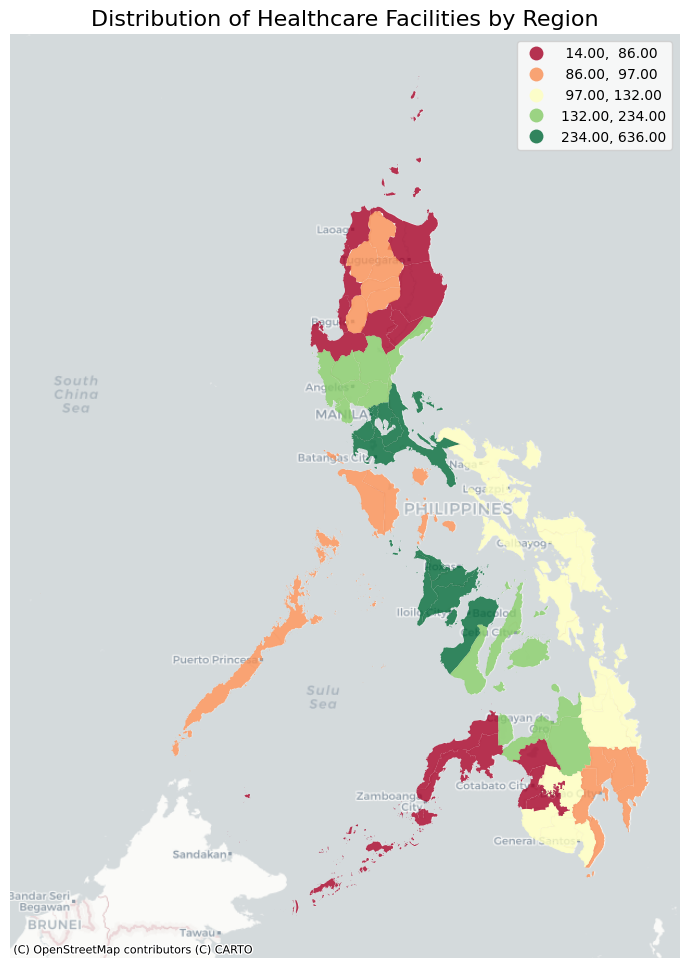

In [ ]:
# Plot Distribution of Healthcare Facilities by Region
fig,ax = plt.subplots(figsize=(12,12))

regional_healthsites.plot(ax=ax,
        column='healthsites_count',
        legend=True,
        alpha=0.8,
        cmap='RdYlGn',
        scheme='quantiles')

ax.axis('off')
ax.set_title('Distribution of Healthcare Facilities by Region', fontsize=16)
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

> *Insights*
- There were high clusters of healthcare facilities in Center Luzon and Western Visayas but we're interested more on the low clusters happened at Northern Luzon and Western Mindanao


> *Next Step*
- Correlate regional distribution of healthcare facilites with the dengue fatalites then obtain and compare clustering of healthcare facilities and dengue fatalities using Local Moran


# **9. Correlation of Healthcare Facilities with Dengue Fatality Rates**

Correlation refers to a statistical measures that express to which extent two variables are linearly related and in this section, the two variables are indeed the healthcare facilities and dengue fatalities displayed regionally. We will use Pearson correlation coefficient which ranges from -1 to +1.

Types of Correlation:
- **Positive Correlation** indicates both variable increase or decrease together
decrease
- **Zero Correlation** indicates there is no linear correlation between variables
- **Negative Correlation** indicates as one variable increases, the other tend to

*  **Score closer to 1** indicates strong linear relationship
*   **Score closer to 0 (either positve or negative)** indicates weak linear relationship
*   **Score closer to -1** indicates strong negative linear relationship

### 9.1 Correlation Score and Scatter Plot

In [ ]:
# Merge data of regional healthcare facilities and regional dengue fatalities
healthsites_dengue_deaths_joined = regional_healthsites.merge(dengue_regional_deaths_total, on="region")

# Get correlation value
correlation, p_value = pearsonr(healthsites_dengue_deaths_joined['Dengue_Deaths_Per_100_Cases'], healthsites_dengue_deaths_joined['healthsites_count'])
correlation

-0.08933987253291839

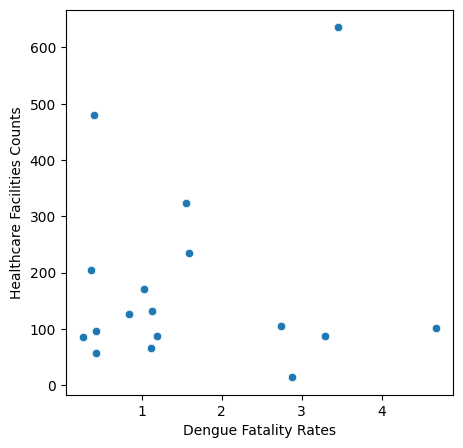

In [ ]:
# Plot correlation scatter plot
plt.figure(figsize=(5,5))
sns.scatterplot(x='Dengue_Deaths_Per_100_Cases', y='healthsites_count', data=healthsites_dengue_deaths_joined)
plt.xlabel('Dengue Fatality Rates')
plt.ylabel('Healthcare Facilities Counts')
plt.show()

> *Discussion:*
- From the correlation value of -0.09, we see that we have a slight inverse correlation (even at the plot) between the number of healthcare facilities and the dengue fatality rates, indicating that as the number of healthcare facilities increases, dengue fatality rates tend to decrease, and as the number of healthcare facilities decreases, dengue fatality rates tend to increases.

### 9.2 Clustering Map for Healthcare Facilities and Dengue Fatality Rates using Local Moran


We will use Local Moran to identify clusters between regions and map it. Clusters are classified as:

* **High-High** indicates regions with high values surrounded with neighbors of high values
* **Low-High** indicates regions with low values surrounded with neighbors of high values
* **Low-Low** indicates regions with low values surrounded with neighbors of low values
* **High-Low** indicates regions with high values surrounded with neighbors of low values

In [ ]:
# Calculate spatial weights for regional healthcare facilities
w_sites = libpysal.weights.DistanceBand.from_dataframe(regional_healthsites, threshold=500000, binary=True)
w_sites.transform = 'r'

# Get moran local clusterings for healthcare facilities and dengue fatalities
lisa_sites = Moran_Local(regional_healthsites['healthsites_count'], w_sites)
lisa_deaths = Moran_Local(dengue_regional_deaths_total['Dengue_Deaths_Per_100_Cases'], w_deaths)

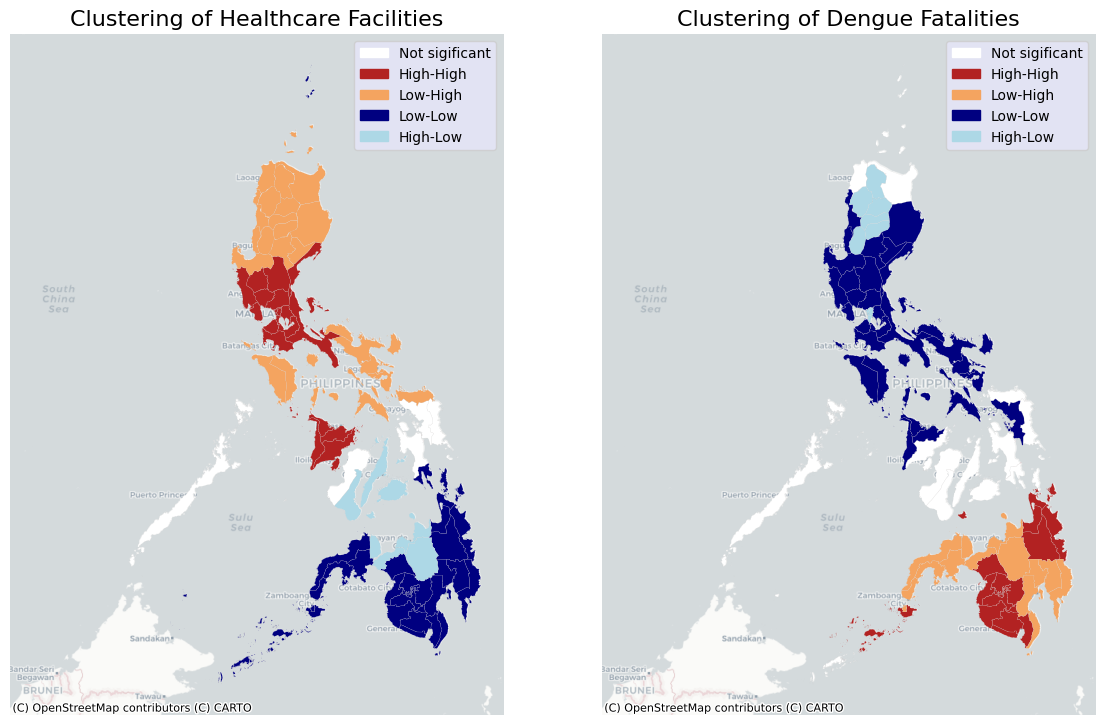

In [ ]:
# Plot moran local clusterings for healthcare facilities and dengue fatalities
fig, axes = plt.subplots(1, 2, figsize=(14,14))

regional_healthsites[lisa_sites.p_sim > 0.05].plot(ax=axes[0], color='white', edgecolor='lightgrey', lw=0.1)
regional_healthsites[(lisa_sites.q == 1) & (lisa_sites.p_sim <= 0.05)].plot(ax=axes[0], color='firebrick', edgecolor='lightgrey',  lw=0.1)
regional_healthsites[(lisa_sites.q == 2) & (lisa_sites.p_sim <= 0.05)].plot(ax=axes[0], color='sandybrown', edgecolor='lightgrey',  lw=0.1)
regional_healthsites[(lisa_sites.q == 3) & (lisa_sites.p_sim <= 0.05)].plot(ax=axes[0], color='navy', edgecolor='lightgrey', lw=0.1)
regional_healthsites[(lisa_sites.q == 4) & (lisa_sites.p_sim <= 0.05)].plot(ax=axes[0], color='lightblue', edgecolor='lightgrey', lw=0.1)

handles = [
    mpatches.Patch(color='white', label='Not sigificant'),
    mpatches.Patch(color='firebrick', label='High-High'),
    mpatches.Patch(color='sandybrown', label='Low-High'),
    mpatches.Patch(color='navy', label='Low-Low'),
    mpatches.Patch(color='lightblue', label='High-Low')
]

axes[0].legend(handles=handles, loc='upper right').get_frame().set_facecolor('lavender')
axes[0].axis('off')
axes[0].set_title('Clustering of Healthcare Facilities', fontsize=16)
ctx.add_basemap(axes[0],source=ctx.providers.CartoDB.Positron)


dengue_regional_deaths_total[lisa_deaths.p_sim > 0.05].plot(ax=axes[1], color='white', edgecolor='lightgrey', lw=0.1)
dengue_regional_deaths_total[(lisa_deaths.q == 1) & (lisa_deaths.p_sim <= 0.05)].plot(ax=axes[1], color='firebrick', edgecolor='lightgrey', lw=0.1)
dengue_regional_deaths_total[(lisa_deaths.q == 2) & (lisa_deaths.p_sim <= 0.05)].plot(ax=axes[1], color='sandybrown',  edgecolor='lightgrey', lw=0.1)
dengue_regional_deaths_total[(lisa_deaths.q == 3) & (lisa_deaths.p_sim <= 0.05)].plot(ax=axes[1], color='navy', edgecolor='lightgrey', lw=0.1)
dengue_regional_deaths_total[(lisa_deaths.q == 4) & (lisa_deaths.p_sim <= 0.05)].plot(ax=axes[1], color='lightblue', edgecolor='lightgrey', lw=0.1)

handles = [
    mpatches.Patch(color='white', label='Not sigificant'),
    mpatches.Patch(color='firebrick', label='High-High'),
    mpatches.Patch(color='sandybrown', label='Low-High'),
    mpatches.Patch(color='navy', label='Low-Low'),
    mpatches.Patch(color='lightblue', label='High-Low')
]

axes[1].legend(handles=handles, loc='upper right').get_frame().set_facecolor('lavender')
axes[1].axis('off')
axes[1].set_title('Clustering of Dengue Fatalities', fontsize=16)
ctx.add_basemap(axes[1],source=ctx.providers.CartoDB.Positron)

> *Discussion:*
- Since dengue fatalities is slightly inversed with the number of healthcare facities regionally, we can see from the maps that part of hotspots from the clusters of healthcare facilities became cold spots from the clusters of dengue fatalities and part of cold spots from the healthcare facilities became hotspots from the dengue fatalities

> *Next Step*
- Determine regions with low survival rate and with low access to healthcare facilities using spatial join between the 2 clustered maps


# **10. Low Survival Rate Regions with Low Access to Healthcare**



In [ ]:
# Get regions with low clustering of healthcare facilities (Low-Low)
low_low_health_sites = regional_healthsites[(lisa_sites.q == 3) & (lisa_sites.p_sim <= 0.05)]

# Get regions with high clustering of dengue fatallities (High-High)
high_high_dengue_fatalities = dengue_regional_deaths_total[(lisa_deaths.q == 1) & (lisa_deaths.p_sim <= 0.05)]

# Spatial join to get intersecting regions for high dengue fatalities cluster and low healthcare facilities cluster
intersects = gpd.sjoin(high_high_dengue_fatalities, low_low_health_sites, how='inner')

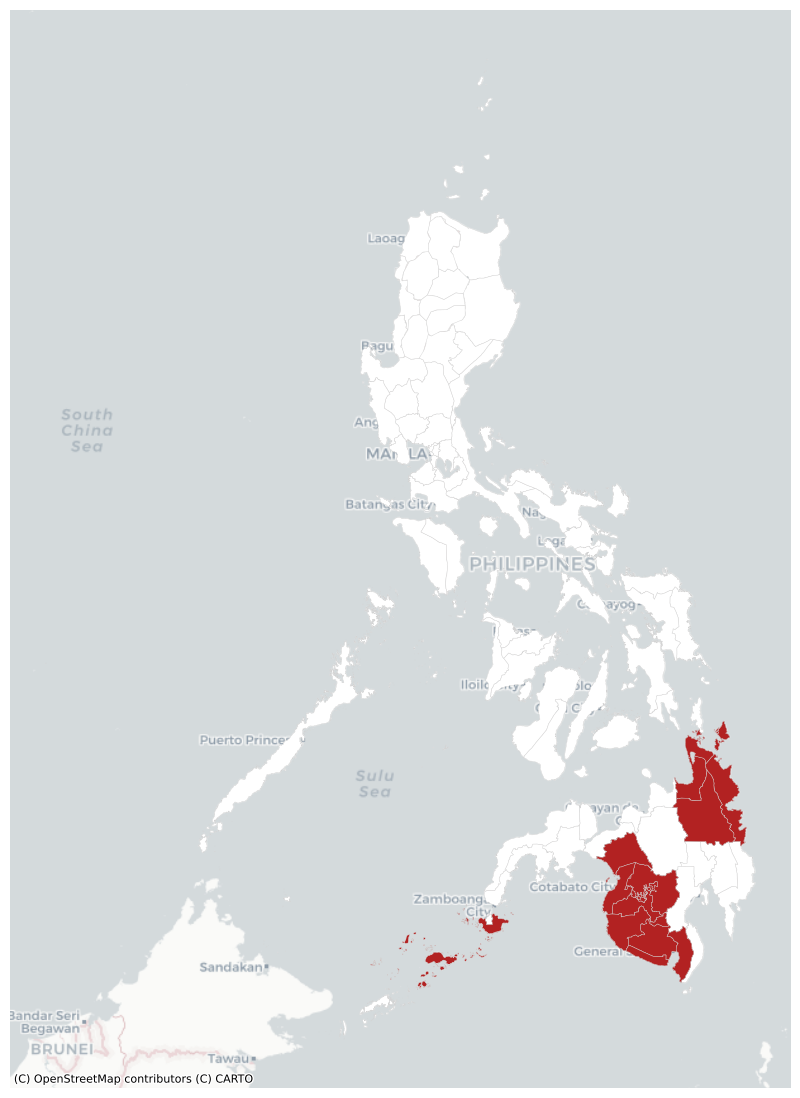

In [ ]:
# Plot regions of low healthcare facilites and high dengue fatalities
fig, ax = plt.subplots(figsize=(14,14))

# Plot basemap
regional_geojsons.plot(ax=ax,
         color='white',
         edgecolor='lightgrey',
         lw=0.3)

# Overlay regions of low healthcare facilites and high dengue fatalities
intersects.plot(ax=ax, color='firebrick', edgecolor='lightgrey', lw=0.3)

ax.axis('off')
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

> *Discussion:*
- There are few regions that has low access to healthcare facilities but in response to coping with dengue cases recently, these are the regions that is indeed in need of considerations.

In [ ]:
print(intersects['region_left'].unique())

['Region XII' 'BARMM' 'Region XIII']
